# Training with subset of data

In [1]:
import joblib
import logging
from BSOID.bsoid import BSOID

logging.basicConfig(level=logging.INFO)

In [2]:
%matplotlib inline
import seaborn as sn
sn.set_theme()

In [23]:
bsoid = BSOID.load_config('D:/IIT/DDP/data', 'temporal_feats')
assignments, soft_clusters, soft_assignments = bsoid.load_identified_clusters()

In [8]:
import pandas as pd
import numpy as np

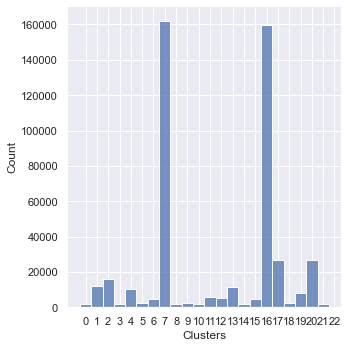

In [26]:
cluster_data = pd.Series(data=assignments, name='Clusters')
ax = sn.displot(cluster_data, kind='hist', bins=np.arange(soft_assignments.max() + 1) - 0.5)
ax.set(xticks=np.unique(soft_assignments))

---
# splitting major clusters

In [9]:
with open(bsoid.output_dir + '/' + bsoid.run_id + '_umap.sav', 'rb') as f:
    _, feats_sc = joblib.load(f)

In [10]:
idx = np.where(soft_assignments == 13)[0]
feats_sc = feats_sc[idx]

In [11]:
import hdbscan

In [ ]:
min_cluster_prop = 0.95
min_cluster_size = int(round(min_cluster_prop * 0.01 * feats_sc.shape[0]))
print('clustering {} samples in {}D with HDBSCAN for a minimum cluster size of {}'.format(*feats_sc.shape, min_cluster_size))
clusterer = hdbscan.HDBSCAN(min_cluster_size, min_samples=10, prediction_data=True).fit(feats_sc)
assignments = clusterer.labels_
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_assignments = np.argmax(soft_clusters, axis=1)
print('Identified {} clusters'.format(len(np.unique(soft_assignments))))

clustering 208479 samples in 10D with HDBSCAN for a minimum cluster size of 1981


In [ ]:
cluster_data = pd.Series(data=assignments, name='Clusters')
ax = sn.displot(cluster_data, kind='hist', bins=np.unique(soft_assignments)- 0.5)
ax.set(xticks=np.unique(soft_assignments))

---
# clustering subset of 20D directly

In [6]:
import hdbscan
import numpy as np
from sklearn.preprocessing import StandardScaler
bsoid = BSOID.load_config('/Users/dhruvlaad/IIT/DDP/data', 'temporal_feats')

In [5]:
feats, _ = bsoid.load_features()
feats_sc = StandardScaler().fit_transform(feats)
idx = np.random.permutation(np.arange(feats_sc.shape[0]))[:int(6e5)]
feats_sc = feats_sc[idx]

In [ ]:
min_cluster_prop = 0.85
min_cluster_size = int(round(min_cluster_prop * 0.01 * feats_sc.shape[0]))
logging.info('clustering {} samples in {}D with HDBSCAN for a minimum cluster size of {}'.format(*feats_sc.shape, min_cluster_size))
clusterer = hdbscan.HDBSCAN(min_cluster_size, min_samples=10, prediction_data=True).fit(feats_sc)
assignments = clusterer.labels_
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_assignments = np.argmax(soft_clusters, axis=1)
logging.info('identified {} clusters from {} samples in {}D'.format(len(np.unique(assignments)), *feats_sc.shape))

INFO:root:clustering 600000 samples in 20D with HDBSCAN for a minimum cluster size of 5100


In [17]:
np.where(soft_assignments == 11)[0].size

1291